# Text Classification:

## Data
<pre>
1. we have total of 20 types of documents(Text files) and total 18828 documents(text files). 
2. so from document name, you can extract the label for that document.
3. Now our problem is to classify all the documents into any one of the class.
4. Below we provided count plot of all the labels in our data. 
</pre>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag, ne_chunk
import spacy
import pickle
import spacy_transformers
import torch
import torchvision
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [402]:
files=os.listdir('documents')
doc_number = [doc[doc.index('_')+1:-4] for doc in files]
doc_class = [doc[:doc.index('_')] for doc in files]

In [404]:
df = pd.DataFrame({'doc_num':doc_number,'class':doc_class})
df

,doc_num,class
0,49960,alt.atheism
1,51060,alt.atheism
2,51119,alt.atheism
3,51120,alt.atheism
4,51121,alt.atheism
...,...,...
18823,84564,talk.religion.misc
18824,84565,talk.religion.misc
18825,84568,talk.religion.misc
18826,84569,talk.religion.misc


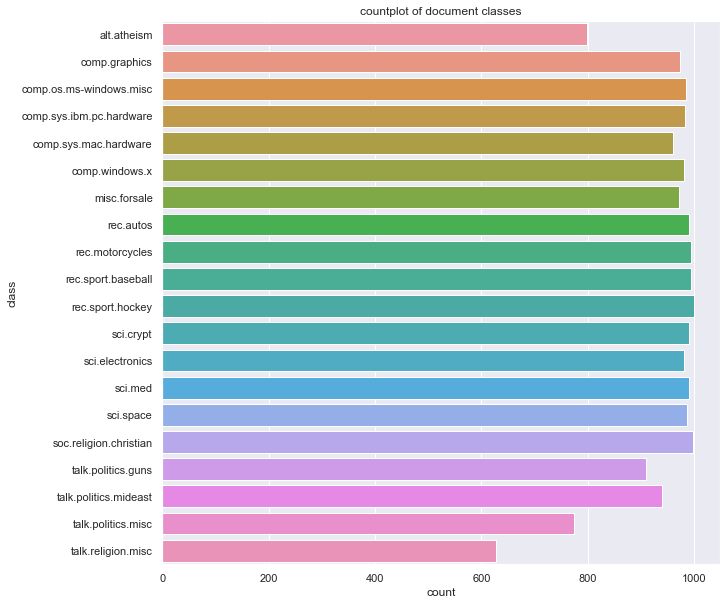

In [405]:
### count plot of all the class labels. 
plt.subplots(figsize = (10,10))
sns.set_theme(style="darkgrid")
sns.countplot(y='class', data=df)
plt.title("countplot of document classes")
plt.show()

#### sample document
<pre>
<font color='blue'>
Subject: A word of advice
From: jcopelan@nyx.cs.du.edu (The One and Only)

In article < 65882@mimsy.umd.edu > mangoe@cs.umd.edu (Charley Wingate) writes:
>
>I've said 100 times that there is no "alternative" that should think you
>might have caught on by now.  And there is no "alternative", but the point
>is, "rationality" isn't an alternative either.  The problems of metaphysical
>and religious knowledge are unsolvable-- or I should say, humans cannot
>solve them.

How does that saying go: Those who say it can't be done shouldn't interrupt
those who are doing it.

Jim
--
Have you washed your brain today?
</font>
</pre>

### Preprocessing:
<pre>
useful links: <a href='http://www.pyregex.com/'>http://www.pyregex.com/</a>

<font color='blue'><b>1.</b></font> Finding all emails in the document and then get the text after the "@". and then splitting those texts by '.' 
after that remove the words whose length is less than or equal to 2 and also remove'com' word and then combine those words by space. 
In one doc, if we have 2 or more mails, get all.
<b>Eg:[test@dm1.d.com, test2@dm2.dm3.com]-->[dm1.d.com, dm3.dm4.com]-->[dm1,d,com,dm2,dm3,com]-->[dm1,dm2,dm3]-->"dm1 dm2 dm3" </b> 
appending all those into one list/array. ( This will give length of 18828 sentences i.e one list for each of the document). 
Some sample output was shown below. 

> In the above sample document there are emails [jcopelan@nyx.cs.du.edu, 65882@mimsy.umd.edu, mangoe@cs.umd.edu]

preprocessing:
[jcopelan@nyx.cs.du.edu, 65882@mimsy.umd.edu, mangoe@cs.umd.edu] ==> [nyx cs du edu mimsy umd edu cs umd edu] ==> 
[nyx edu mimsy umd edu umd edu]

<font color='blue'><b>2.</b></font> Replacing all the emails by space in the original text. 
</pre>

<pre>
<font color='blue'><b>3.</b></font> Getting subject of the text i.e. get the total lines where "Subject:" occur and remove 
the word which are before the ":" remove the newlines, tabs, punctuations, any special chars.
<b>Eg: if we have sentance like "Subject: Re: Gospel Dating @ \r\r\n" --> You have to get "Gospel Dating"</b> 
Save all this data into another list/array. 

<font color='blue'><b>4.</b></font> After storing it in the list, Replacing those sentences in original text by space.

<font color='blue'><b>5.</b></font> Deleting all the sentences where sentence starts with <b>"Write to:"</b> or <b>"From:"</b>.
> In the above sample document check the 2nd line, we should remove that

<font color='blue'><b>6.</b></font> Deleting all the tags like "< anyword >"
> In the above sample document check the 4nd line, we should remove that "< 65882@mimsy.umd.edu >"


<font color='blue'><b>7.</b></font> Deleting all the data which are present in the brackets. 
In many text data, I observed that, they maintained the explanation of sentence 
or translation of sentence to another language in brackets so remove all those.
<b>Eg: "AAIC-The course that gets you HIRED(AAIC - Der Kurs, der Sie anstellt)" --> "AAIC-The course that gets you HIRED"</b>

> In the above sample document check the 4nd line, we should remove that "(Charley Wingate)"


<font color='blue'><b>8.</b></font> Removing all the newlines('\n'), tabs('\t'), "-", "\".

<font color='blue'><b>9.</b></font> Removing all the words which ends with <b>":"</b>.
<b>Eg: "Anyword:"</b>
> In the above sample document check the 4nd line, we should remove that "writes:"


<font color='blue'><b>10.</b></font> Decontractions, replacing words like below to full words. 
<b>Eg: can't -> can not, 's -> is, i've -> i have, i'm -> i am, you're -> you are, i'll --> i will </b>

<b> There is no order to do point 6 to 10</b>

<font color='blue'><b>11.</b></font> Chunking on the text we have after above preprocessing. 
Text chunking, also referred to as shallow parsing, is a task that 
follows Part-Of-Speech Tagging and that adds more structure to the sentence.
So it combines the some phrases, named entities into single word.
So after that combine all those phrases/named entities by separating <b>"_"</b>. 
And removing the phrases/named entities if that is a "Person". 
We can use <b>nltk.ne_chunk</b> to get these. 
Below we have given one example. please go through it. 

useful links: 
<a href='https://www.nltk.org/book/ch07.html'>https://www.nltk.org/book/ch07.html</a>
<a href='https://stackoverflow.com/a/31837224/4084039'>https://stackoverflow.com/a/31837224/4084039</a>
<a href='http://www.nltk.org/howto/tree.html'>http://www.nltk.org/howto/tree.html</a>
<a href='https://stackoverflow.com/a/44294377/4084039'>https://stackoverflow.com/a/44294377/4084039</a>
</pre>

<pre>We did chunking for above two lines and then We got one list where each word is mapped to a 
POS(parts of speech) and also if we see "New York" and "Srikanth Varma", 
they got combined and represented as a tree and "New York" was referred as "GPE" and "Srikanth Varma" was referred as "PERSON". 
so now we have to Combine the "New York" with <b>"_"</b> i.e "New_York"
and remove the "Srikanth Varma" from the above sentence because it is a person.</pre>

<pre>
<font color='blue'><b>13.</b></font> Replacing all the digits with space i.e deleting all the digits. 
> In the above sample document, the 6th line have digit 100, so we have to remove that.

<font color='blue'><b>14.</b></font> After doing above points, we observed there might be few word's like
 <b> "_word_" (i.e starting and ending with the _), "_word" (i.e starting with the _),
  "word_" (i.e ending with the _)</b> remove the <b>_</b> from these type of words. 

<font color='blue'><b>15.</b></font>  We also observed some words like <b> "OneLetter_word"- eg: d_berlin, 
"TwoLetters_word" - eg: dr_berlin </b>, in these words we remove the "OneLetter_" (d_berlin ==> berlin) and 
"TwoLetters_" (de_berlin ==> berlin). i.e remove the words 
which are length less than or equal to 2 after spliiting those words by "_". 

<font color='blue'><b>16.</b></font> Converting all the words into lower case and lowe case 
and removing the words which are greater than or equal to 15 or less than or equal to 2.

<font color='blue'><b>17.</b></font> replacing all the words except "A-Za-z_" with space. 

<font color='blue'><b>18.</b></font> Now we got Preprocessed Text, email, subject. creating a dataframe with those. 
Below are the columns of the df. 
</pre>

In [408]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

### To get above mentioned data frame --> Try to Write Total Preprocessing steps in One Function Named Preprocess as below. 

In [407]:
def preprocess(Input_Text,doc):
    """Do all the Preprocessing as shown above and
    return a tuple contain preprocess_email,preprocess_subject,preprocess_text for that Text_data"""
    
    #Input_Text = Input_Text_File.read()
    file = open('documents/'+doc)
    Input_Text_Line = file.readlines()

    preprocessed_email = []
    texts = []
    subjects = []
    
    #for email
    lst = re.findall('@\S+[a-zA-Z0-9]', Input_Text)
    text = re.sub('[a-zA-Z0-9]\S+@\S+[a-zA-Z0-9]', ' ', Input_Text)
    new_lst =[]
    for email in lst:
        email = email[1:]
        new_lst.extend(email.split('.'))

    new_lst = [i for i in new_lst if len(i)>2 and i!='com' and i!='Com' and i!='COM']
    preprocessed_string = (' ').join(new_lst)
    preprocessed_string = preprocessed_string.lower()
        
    #for text
    c=0
    #print(Input_Text_List)
    for line in Input_Text_Line:
        if 'Subject:' in line:
            if c == 0:
                a = re.sub('.*\:','',line)
                b = re.sub("[^a-zA-Z0-9]+", ' ',a)
                subject = b.strip()
                subject = subject.lower()
                c+=1
            text = text.replace(line,' ')

        if 'Write to:' in line:
            text = text.replace(line,'')

        if 'From:' in line:
            line = re.sub('[a-zA-Z0-9]\S+@\S+[a-zA-Z0-9]', ' ', line)
            text = text.replace(line,'')

    text = re.sub('<.*?>','',text)

    text = re.sub('\(.*?\)','',text)

    text = re.sub('[\-]','',text)

    text = re.sub('\w+:','',text)

    text = re.sub('[\t\\\]','',text)

    text = re.sub('\n+',' ',text)

    text = re.sub('[0-9]','',text)

    text = re.sub(r'\b\w{1,2}\b','',text)

    text = re.sub(r'\b\w{15,}\b','',text)

    text = decontracted(text)
    
    #Chunking using spacy
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            text = text.replace(ent.text,'')
        if ent.label_ == 'GPE':
            if ' ' in ent.text:
                gpe = ent.text
                gpe = gpe.replace(' ','_')
                text =  text.replace(ent.text,gpe)
                
    text = text.lower()
    
    text = re.sub('\w*[^A-Za-z_ ]+\w*','',text)
    
    return (preprocessed_string,subject,text)

In [ ]:
#Performing preprocessing for all 18,828 documents.
docs = os.listdir('documents')
preprocessed_email = []
texts = []
subjects = []

for doc in tqdm(docs):
    text_file = open('documents/'+doc)
    input_text = text_file.read()
    preprocessed_email_string,subject,text = preprocess(input_text,doc)
    preprocessed_email.append(preprocessed_email_string)
    texts.append(text)
    subjects.append(subject)

### Training The models to Classify: 

<pre>
1. Combining "preprocessed_text", "preprocessed_subject", "preprocessed_emails" into one column. using that column to model. 

2. Spliting the data into Train and test. use 25% for test also do a stratify split. 

3. Analyzing your text data and pad the sequnce if required. 
Sequnce length is not restricted, you can use anything of your choice. 
you need to give the reasoning

4. Doing Tokenizer i.e converting text into numbers.

5. Coding the model's ( Model-1, Model-2 ) as discussed below 
and trying to optimize that models.  

6. For every model using predefined Glove vectors. 

7. Using "categorical_crossentropy" as Loss. 

8. Using <b>Accuracy and Micro Avgeraged F1 score</b> as Key metrics to evaluate our model. 

</pre>

### Model-1: Using 1D convolutions with word embeddings

<pre>
<b>Encoding of the Text </b>

<b>Reference:</b>
<a href='https://stackoverflow.com/a/43399308/4084039'>https://stackoverflow.com/a/43399308/4084039</a>
<a href='https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/'>https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/</a>

</pre>

### Model-2 : Using 1D convolutions with character embedding

<pre>
<pre>
Here are the some papers based on Char-CNN
 1. Xiang Zhang, Junbo Zhao, Yann LeCun. <a href="http://arxiv.org/abs/1509.01626">Character-level Convolutional Networks for Text Classification</a>.NIPS 2015
 2. Yoon Kim, Yacine Jernite, David Sontag, Alexander M. Rush. <a href="https://arxiv.org/abs/1508.06615">Character-Aware Neural Language Models</a>. AAAI 2016
 3. Shaojie Bai, J. Zico Kolter, Vladlen Koltun. <a href="https://arxiv.org/pdf/1803.01271.pdf">An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling</a>
 4. Using the pratrained char embeddings <a href='https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt'>https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt</a>
</pre>

In [223]:
data = pd.DataFrame({'text':t,'class':doc_class,'preprocessed_text':texts,'preprocessed_subject':subjects,'preprocessed_emails':preprocessed_email})
data

,text,class,preprocessed_text,preprocessed_subject,preprocessed_emails
0,From: mathew <mathew@mantis.co.uk>\nSubject: A...,alt.atheism,resources december ...,atheist resources,mantis netcom mantis
1,From: mathew <mathew@mantis.co.uk>\nSubject: A...,alt.atheism,introduction april begin pgp signed ...,introduction to atheism,mantis mantis mantis
2,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,alt.atheism,article has quite not necessaril...,gospel dating,dbstu1 tu-bs mimsy umd edu umd edu
3,From: mathew <mathew@mantis.co.uk>\nSubject: R...,alt.atheism,ras have been ordered none have ...,university violating separation of church state,mantis kepler unh edu
4,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,alt.atheism,article hate economic terrorism an...,soc motss et al princeton axes matching funds ...,watson ibm harder ccr-p ida org harder ccr-p i...
...,...,...,...,...,...
18823,From: sbuckley@fraser.sfu.ca (Stephen Buckley)...,talk.religion.misc,sure this was the right newsgrou...,religion and marriage,fraser sfu magnus acs ohio-state edu
18824,From: bakerj@gtephx.UUCP (Jon Baker)\nSubject:...,talk.religion.misc,article article bu...,how do you know what happened,gtephx uucp ifi uio ifi uio ncratl atlantaga n...
18825,From: pharvey@quack.kfu.com (Paul Harvey)\nSub...,talk.religion.misc,article you would like understand b...,why did they behave as they did waco reading s...,quack kfu emx utexas edu emx utexas edu
18826,From: <KEVXU@CUNYVM.BITNET>\nSubject: Re: Info...,talk.religion.misc,article danger anticult groups that ...,info about new age,cunyvm bitnet digi lonestar org digi lonestar org


In [228]:
dataset = open('data','wb')
pickle.dump(data,dataset)
dataset.close()

In [2]:
file_to_read = open("data", "rb")
data = pickle.load(file_to_read)

In [6]:
data = data.rename(columns={"text":"raw_text"})
data["text"] = data["preprocessed_text"] + data["preprocessed_subject"] + data["preprocessed_emails"]
data_class = data['class']
data = data.drop(['raw_text','class','preprocessed_text', 'preprocessed_subject','preprocessed_emails'], axis = 1)

In [7]:
#Splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(data, data_class, test_size=0.25, random_state=15,stratify = data_class)

# Word Embeddngs

In [10]:
sentences = list(X_train['text'])
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
tokenizer.index_word

{1: '<OOV>',
 2: 'the',
 3: 'and',
 4: 'that',
 5: 'for',
 6: 'you',
 7: 'have',
 8: 'are',
 9: 'edu',
 10: 'this',
 11: 'with',
 12: 'not',
 13: 'was',
 14: 'but',
 15: 'they',
 16: 'from',
 17: 'can',
 18: 'would',
 19: 'what',
 20: 'will',
 21: 'all',
 22: 'about',
 23: 'there',
 24: 'one',
 25: 'your',
 26: 'has',
 27: 'article',
 28: 'any',
 29: 'who',
 30: 'some',
 31: 'which',
 32: 'their',
 33: 'were',
 34: 'when',
 35: 'like',
 36: 'just',
 37: 'more',
 38: 'out',
 39: 'get',
 40: 'how',
 41: 'people',
 42: 'other',
 43: 'had',
 44: 'than',
 45: 'been',
 46: 'only',
 47: 'his',
 48: 'know',
 49: 'think',
 50: 'does',
 51: 'use',
 52: 'also',
 53: 'then',
 54: 'these',
 55: 'could',
 56: 'should',
 57: 'them',
 58: 'because',
 59: 'into',
 60: 'even',
 61: 'may',
 62: 'good',
 63: 'very',
 64: 'those',
 65: 'make',
 66: 'many',
 67: 'new',
 68: 'two',
 69: 'much',
 70: 'see',
 71: 'most',
 72: 'why',
 73: 'our',
 74: 'time',
 75: 'such',
 76: 'its',
 77: 'after',
 78: 'anyone',

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
sentences_test = list(X_test['text'])
sequences_test = tokenizer.texts_to_sequences(sentences_test)

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 0, 'Text Sequence Lengths')

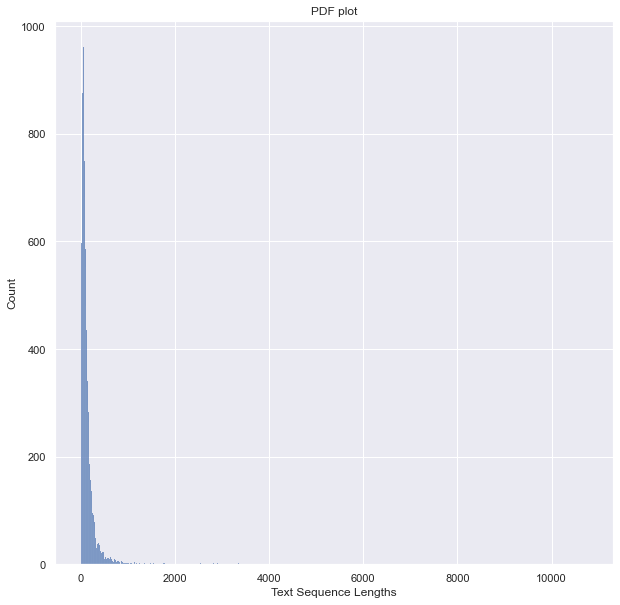

In [420]:
sequence_lengths = [len(i) for i in sequences]
plt.subplots(figsize = (10,10))
print(sns.histplot(data=sequence_lengths))
plt.title('PDF plot')
plt.xlabel('Text Sequence Lengths')

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 0, 'Text Sequence Lengths')

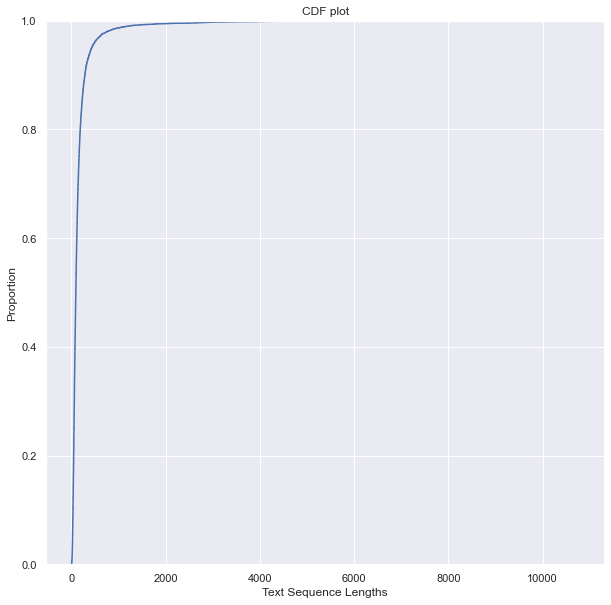

In [421]:
plt.subplots(figsize = (10,10))
print(sns.ecdfplot(data=sequence_lengths))
plt.title('CDF plot')
plt.xlabel('Text Sequence Lengths')

In [417]:
#Calculating 98th percentile
np.percentile(sequence_lengths,98)

761.2000000000007

In [17]:
padded_train=pad_sequences(sequences,maxlen=700)
padded_train.shape

(14121, 700)

In [19]:
padded_test = pad_sequences(sequences_test,maxlen=700)
padded_test.shape

(4707, 700)

In [21]:
import pickle
with open('glove_vectors', 'rb') as f:
    glove_dict = pickle.load(f)
    glove_words =  set(glove_dict.keys())

In [27]:
#Embedding Matrix
embedding_matrix = np.zeros((len(tokenizer.index_word)+1,300))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [102]:
# one_hot_encoding labels
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(sparse = False)
y_train_encoded= onehotencoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = onehotencoder.fit_transform(y_test.values.reshape(-1, 1))

In [103]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train.values)
y_train_label_encoded = le.transform(y_train.values)
y_test_label_encoded = le.transform(y_test.values)

# Model 1

In [ ]:
#callback for micro F1 score

class Metrics(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'acc': [],'val_loss': [],'val_acc': [], 'micro_f1_score': [], 'val_micro_f1_score': [], 'auc': [], 'val_auc': []}
        
    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        self.history['loss'].append(logs.get('loss'))
        self.history['acc'].append(logs.get('acc'))
        self.history['auc'].append(logs.get('auc_2'))
        self.history['val_auc'].append(logs.get('val_auc_2'))
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_acc', -1) != -1:
            self.history['val_acc'].append(logs.get('val_acc'))
            
        y_pred_train = self.model.predict(padded_train)
        y_pred_test = self.model.predict(padded_test)
        
        y_train_pred = np.argmax(y_pred_train,axis=1)
        y_test_pred = np.argmax(y_pred_test,axis=1)
        
        f1_score_train = f1_score(y_train_label_encoded, y_train_pred, average='micro')
        f1_score_test = f1_score(y_test_label_encoded, y_test_pred, average='micro')
        
        print('micro_f1_score',f1_score_train)
        print('val_micro_f1_score',f1_score_test)
        
        if(logs['accuracy']>0.70 and logs['val_accuracy']>0.70 and logs['accuracy']<0.73):# and logs.get('val_acc')<0.7)
            self.model.stop_training = True
        
        #print(y_pred[:10])
        #print(logs.keys())

In [108]:
#callback for learning rate decay

from tensorflow.python.keras import backend as K

class Lr_rate_decay(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.history={'loss': [],'acc': [],'val_loss': [],'val_acc': []}
        
    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        current_lr = K.get_value(self.model.optimizer.lr)
        if((epoch+1)%3==0):
            current_lr = current_lr - (0.05*current_lr)
            K.set_value(self.model.optimizer.lr, K.get_value(current_lr))
            
        if(epoch >= 1) and (logs['val_accuracy'] < self.history['val_acc'][-1]):
            changed = current_lr - (0.1*current_lr)
            K.set_value(self.model.optimizer.lr, K.get_value(changed))
        
        self.history['val_acc'].append(logs['val_accuracy'])

In [373]:
vocab_size = len(tokenizer.index_word)
input_length = 700

In [382]:
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
import datetime

inputs = Input(shape=(input_length,))
embedding = Embedding(vocab_size+1, 300,weights=[embedding_matrix],trainable=False)(inputs)
conv11 = Conv1D(filters=16, kernel_size=2, activation='relu')(embedding)
conv12 = Conv1D(filters=16, kernel_size=2, activation='relu')(embedding)
conv13 = Conv1D(filters=16, kernel_size=2, activation='relu')(embedding)
merge1 = concatenate([conv11, conv12, conv13])
pool1 = MaxPooling1D(pool_size=2)(merge1)
conv21 = Conv1D(filters=16, kernel_size=2, activation='relu')(pool1)
conv22 = Conv1D(filters=16, kernel_size=2, activation='relu')(pool1)
conv23 = Conv1D(filters=16, kernel_size=2, activation='relu')(pool1)
merge2 = concatenate([conv21, conv22, conv23])
pool2 = MaxPooling1D(pool_size=2)(merge2)
conv3 = Conv1D(filters=16, kernel_size=2, activation='relu')(pool2)
flat3 = Flatten()(conv3)

drop3 = Dropout(0.5)(flat3)
dense1 = Dense(50, activation='relu')(drop3)
batch_norm1 = BatchNormalization()(dense1)
drop4 = Dropout(0.5)(batch_norm1)

outputs = Dense(20, activation='softmax')(drop4)
model = Model(inputs=inputs, outputs=outputs)

dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

metrics = Metrics()

filepath="model_save/best_model_1.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

log_dir="logs\\fit\\Model_1_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

lr_decay = Lr_rate_decay()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(padded_train,y_train_encoded,epochs=35, validation_data=(padded_test,y_test_encoded), batch_size=32, callbacks=[metrics,checkpoint,lr_decay,early_stopping,tensorboard_callback])

Epoch 1/35
442/442 [==============================] - 93s 198ms/step - loss: 3.4061 - accuracy: 0.0713 - val_loss: 2.4148 - val_accuracy: 0.2105
micro_f1_score 0.24013880036824586
val_micro_f1_score 0.2105374973443807

Epoch 00001: val_accuracy improved from -inf to 0.21054, saving model to model_save\best_model_1.hdf5
Epoch 2/35
442/442 [==============================] - 83s 187ms/step - loss: 2.3360 - accuracy: 0.2269 - val_loss: 1.8130 - val_accuracy: 0.3758
micro_f1_score 0.4095319028397422
val_micro_f1_score 0.37582324198002975

Epoch 00002: val_accuracy improved from 0.21054 to 0.37582, saving model to model_save\best_model_1.hdf5
Epoch 3/35
442/442 [==============================] - 85s 192ms/step - loss: 1.8883 - accuracy: 0.3517 - val_loss: 1.5331 - val_accuracy: 0.4674
micro_f1_score 0.5027972523192409
val_micro_f1_score 0.4673889951136605

Epoch 00003: val_accuracy improved from 0.37582 to 0.46739, saving model to model_save\best_model_1.hdf5
Epoch 4/35
442/442 [============

In [391]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir=logs/fit/Model_1_20210822-041746 --host localhost --port 8089

In [ ]:
%tensorboard --logdir=logs/fit/Model_1_20210822-041746 --host localhost --port 8089

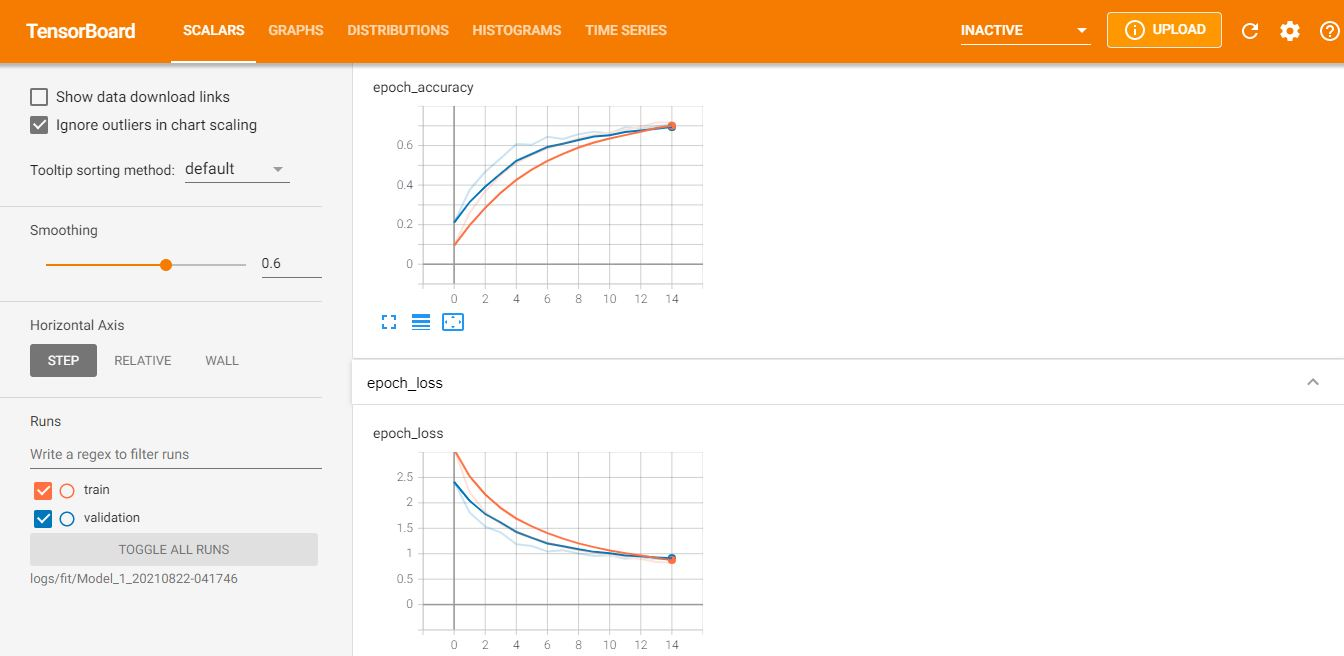

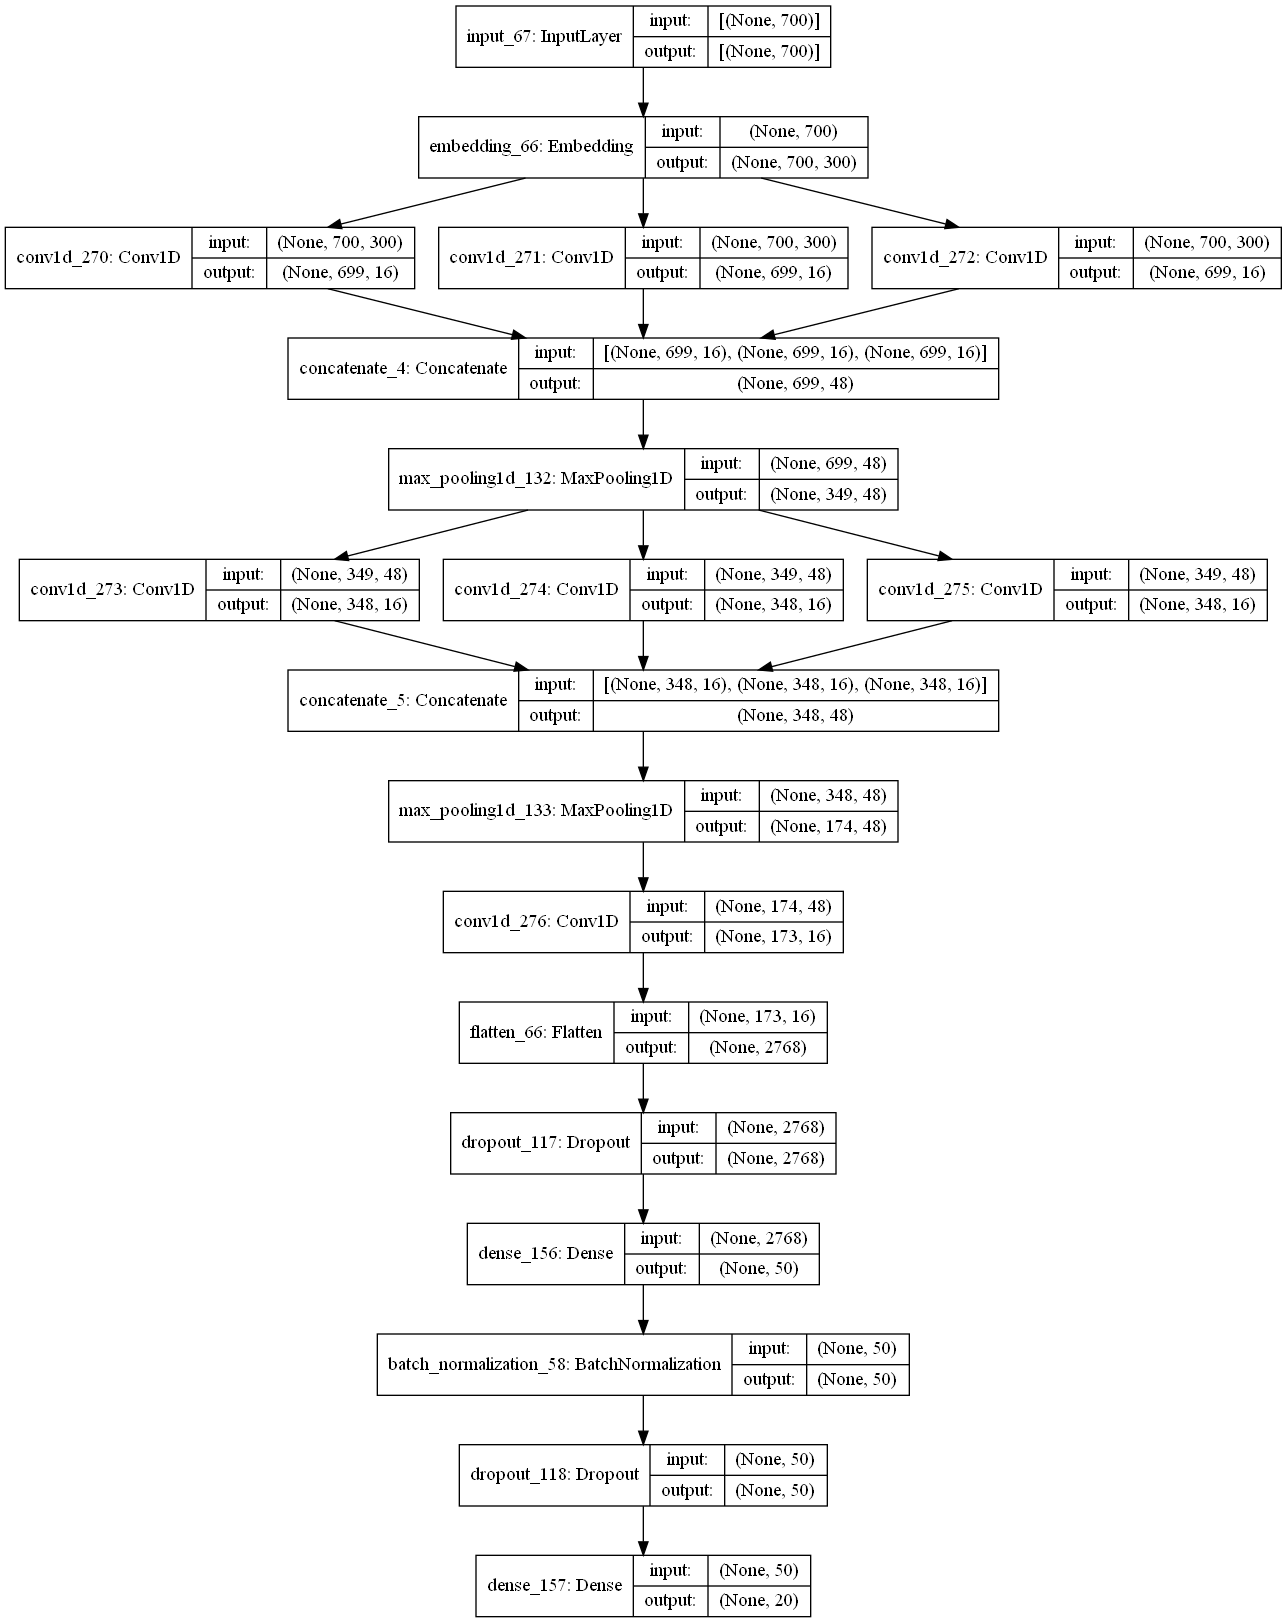

# Character Embeddings

In [45]:
char_embeddings = open('char_embeddings.txt')
char_model = {}
for line in char_embeddings:
    splitline = line.split()
    word = splitline[0]
    embedding = np.array([float(val) for val in splitline[1:]])
    char_model[word] = embedding

In [212]:
char_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n\s',oov_token="<OOV>",char_level = True)
char_tokenizer.fit_on_texts(sentences)
char_tokenizer.index_word

{1: '<OOV>',
 2: ' ',
 3: 'e',
 4: 't',
 5: 'a',
 6: 'o',
 7: 'n',
 8: 'i',
 9: 's',
 10: 'r',
 11: 'h',
 12: 'l',
 13: 'd',
 14: 'u',
 15: 'c',
 16: 'm',
 17: 'p',
 18: 'g',
 19: 'w',
 20: 'y',
 21: 'f',
 22: 'b',
 23: 'v',
 24: 'k',
 25: 'x',
 26: 'j',
 27: 'q',
 28: 'z',
 29: '_',
 30: '1',
 31: '"',
 32: '(',
 33: '0',
 34: '@',
 35: '2',
 36: '-',
 37: '4',
 38: '`',
 39: '3',
 40: '8',
 41: '6',
 42: '5',
 43: '9',
 44: "'",
 45: '!',
 46: '*',
 47: ';',
 48: '7',
 49: '>',
 50: '$',
 51: '#',
 52: '&',
 53: '<',
 54: ',',
 55: '%',
 56: ':',
 57: ')',
 58: '+',
 59: '=',
 60: '\\',
 61: ']',
 62: '/',
 63: '?',
 64: '[',
 65: '^',
 66: '|',
 67: '{',
 68: '}',
 69: '~',
 70: '\x03',
 71: '\x1b'}

In [67]:
#Embedding matrix for character embeddings
char_embedding_matrix = np.zeros((len(char_tokenizer.index_word)+1,300))
for word, i in tqdm(char_tokenizer.word_index.items()):
    embedding_vector = char_model.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        char_embedding_matrix[i] = embedding_vector

100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 17742.83it/s]


In [ ]:
char_sequences = char_tokenizer.texts_to_sequences(sentences)

In [ ]:
sentences_test = list(X_test['text'])
char_sequences_test = char_tokenizer.texts_to_sequences(sentences_test)

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 0, 'Text Sequence Lengths')

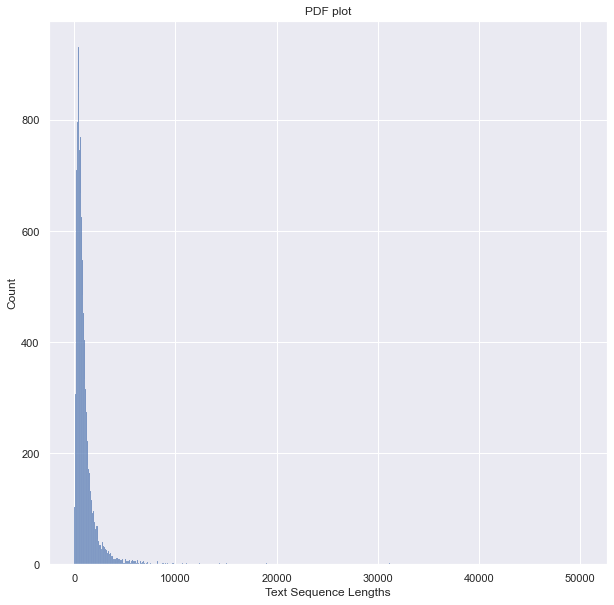

In [423]:
sequence_lengths = [len(i) for i in char_sequences]
plt.subplots(figsize = (10,10))
print(sns.histplot(data=sequence_lengths))
plt.title('PDF plot')
plt.xlabel('Text Sequence Lengths')

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 0, 'Text Sequence Lengths')

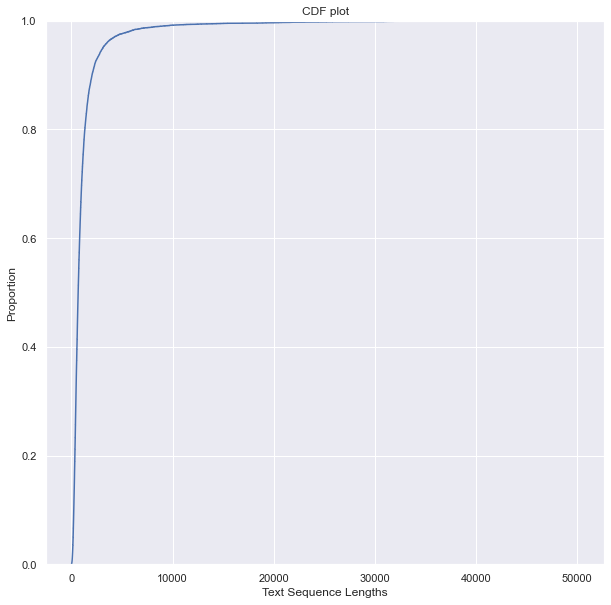

In [424]:
plt.subplots(figsize = (10,10))
print(sns.ecdfplot(data=sequence_lengths))
plt.title('CDF plot')
plt.xlabel('Text Sequence Lengths')

In [401]:
#Calculating 97th percentile
np.percentile(sequence_lengths,97)

4264.799999999999

In [348]:
char_padded_train=pad_sequences(char_sequences,padding='post',maxlen=5000)
char_padded_train.shape

(14121, 5000)

In [346]:
char_padded_test = pad_sequences(char_sequences_test,padding='post',maxlen=5000)
char_padded_test.shape

(4707, 5000)

# Model 2

In [ ]:
#callback for micro F1 score
class Metrics_new(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'acc': [],'val_loss': [],'val_acc': [], 'micro_f1_score': [], 'val_micro_f1_score': [], 'auc': [], 'val_auc': []}
        
    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        self.history['loss'].append(logs.get('loss'))
        self.history['acc'].append(logs.get('acc'))
        self.history['auc'].append(logs.get('auc_2'))
        self.history['val_auc'].append(logs.get('val_auc_2'))
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_acc', -1) != -1:
            self.history['val_acc'].append(logs.get('val_acc'))
            
        y_pred_train = self.model.predict(char_padded_train)
        y_pred_test = self.model.predict(char_padded_test)
        
        y_train_pred = np.argmax(y_pred_train,axis=1)
        y_test_pred = np.argmax(y_pred_test,axis=1)
        
        f1_score_train = f1_score(y_train_label_encoded, y_train_pred, average='micro')
        f1_score_test = f1_score(y_test_label_encoded, y_test_pred, average='micro')
        
        print('micro_f1_score',f1_score_train)
        print('val_micro_f1_score',f1_score_test)
        
        if(logs['accuracy']>0.10 and logs['val_accuracy']>0.10 and logs['accuracy']<0.13):# and logs.get('val_acc')<0.7)
            self.model.stop_training = True
        
        #print(y_pred[:10])
        #print(logs.keys())

In [215]:
char_vocab_size = len(char_tokenizer.index_word)
char_input_length = 5000

In [367]:
inputs = Input(shape=(char_input_length,))
embedding = Embedding(char_vocab_size+1, 300,weights=[char_embedding_matrix],trainable=False)(inputs)
conv1 = Conv1D(filters=8, kernel_size=2, activation='relu')(embedding)
conv2 = Conv1D(filters=8, kernel_size=2, activation='relu')(conv1)
#conv13 = Conv1D(filters=16, kernel_size=2, activation='relu')(embedding)
#merge1 = concatenate([conv11, conv12, conv13])
pool1 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(filters=8, kernel_size=2, activation='relu')(pool1)
conv4 = Conv1D(filters=8, kernel_size=2, activation='relu')(conv3)
#conv23 = Conv1D(filters=16, kernel_size=2, activation='relu')(pool1)
#merge2 = concatenate([conv21, conv22, conv23])
pool2 = MaxPooling1D(pool_size=2)(conv4)
#conv3 = Conv1D(filters=16, kernel_size=2, activation='relu')(pool2)
flat1 = Flatten()(pool2)

drop1 = Dropout(0.5)(flat1)
dense1 = Dense(50, activation='relu')(drop1)
#dense2 = Dense(30, activation='relu')(dense1)
batch_norm1 = BatchNormalization()(dense1)
drop4 = Dropout(0.5)(batch_norm1)

outputs = Dense(20, activation='softmax')(drop4)
model = Model(inputs=inputs, outputs=outputs)

dot_img_file = 'model_2.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

metrics = Metrics_new()

filepath="model_save/best_model_2.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

log_dir="logs\\fit\\Model_2_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

lr_decay = Lr_rate_decay()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(char_padded_train,y_train_encoded,epochs=35, validation_data=(char_padded_test,y_test_encoded), batch_size=32, callbacks=[metrics,checkpoint,lr_decay,early_stopping,tensorboard_callback])

Epoch 1/35
442/442 [==============================] - 205s 453ms/step - loss: 2.9986 - accuracy: 0.0719 - val_loss: 2.9607 - val_accuracy: 0.0839
micro_f1_score 0.08625451455279372
val_micro_f1_score 0.0839175695772254

Epoch 00001: val_accuracy improved from -inf to 0.08392, saving model to model_save\best_model_2.hdf5
Epoch 2/35
442/442 [==============================] - 199s 449ms/step - loss: 2.9384 - accuracy: 0.0744 - val_loss: 2.9192 - val_accuracy: 0.0856
micro_f1_score 0.10240067983853834
val_micro_f1_score 0.08561716592309326

Epoch 00002: val_accuracy improved from 0.08392 to 0.08562, saving model to model_save\best_model_2.hdf5
Epoch 3/35
442/442 [==============================] - 199s 448ms/step - loss: 2.8990 - accuracy: 0.0960 - val_loss: 2.9161 - val_accuracy: 0.0967
micro_f1_score 0.1190425607251611
val_micro_f1_score 0.09666454217123434

Epoch 00003: val_accuracy improved from 0.08562 to 0.09666, saving model to model_save\best_model_2.hdf5
Epoch 4/35
442/442 [=======

In [2]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=logs/fit/Model_2_20210822-032917 --host localhost --port 8088

In [ ]:
%tensorboard --logdir=logs/fit/Model_2_20210822-032917 --host localhost --port 8088

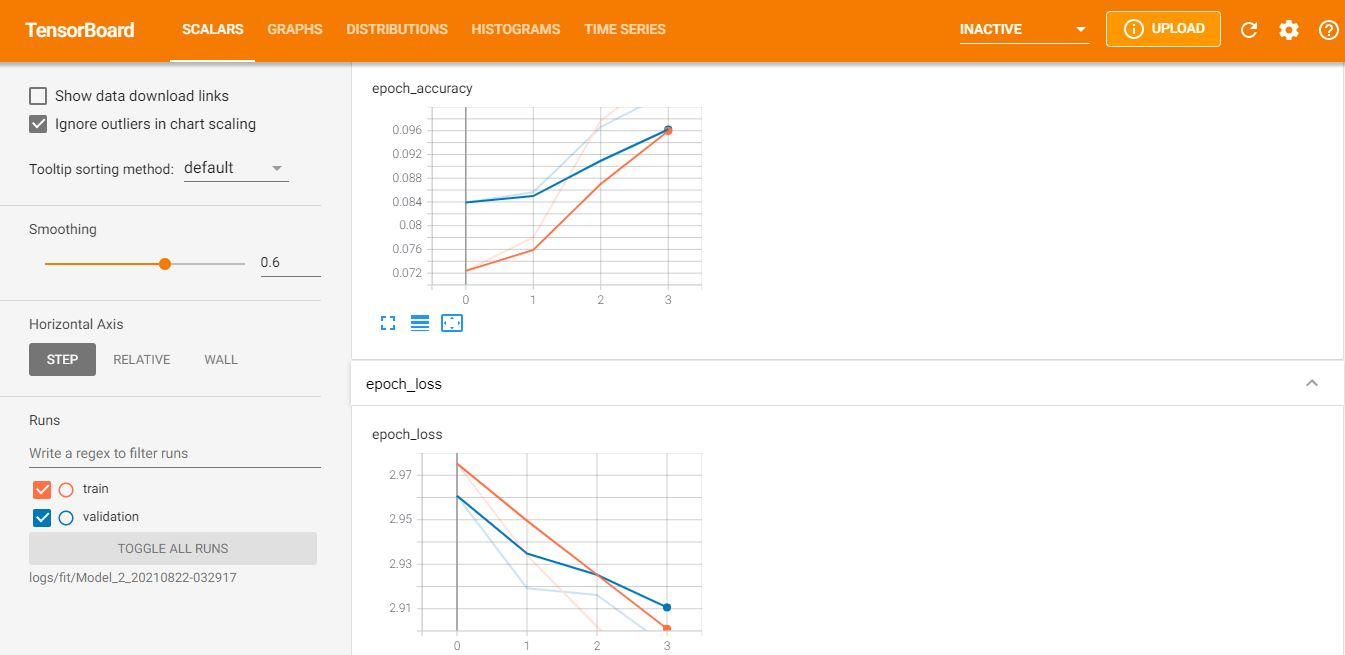

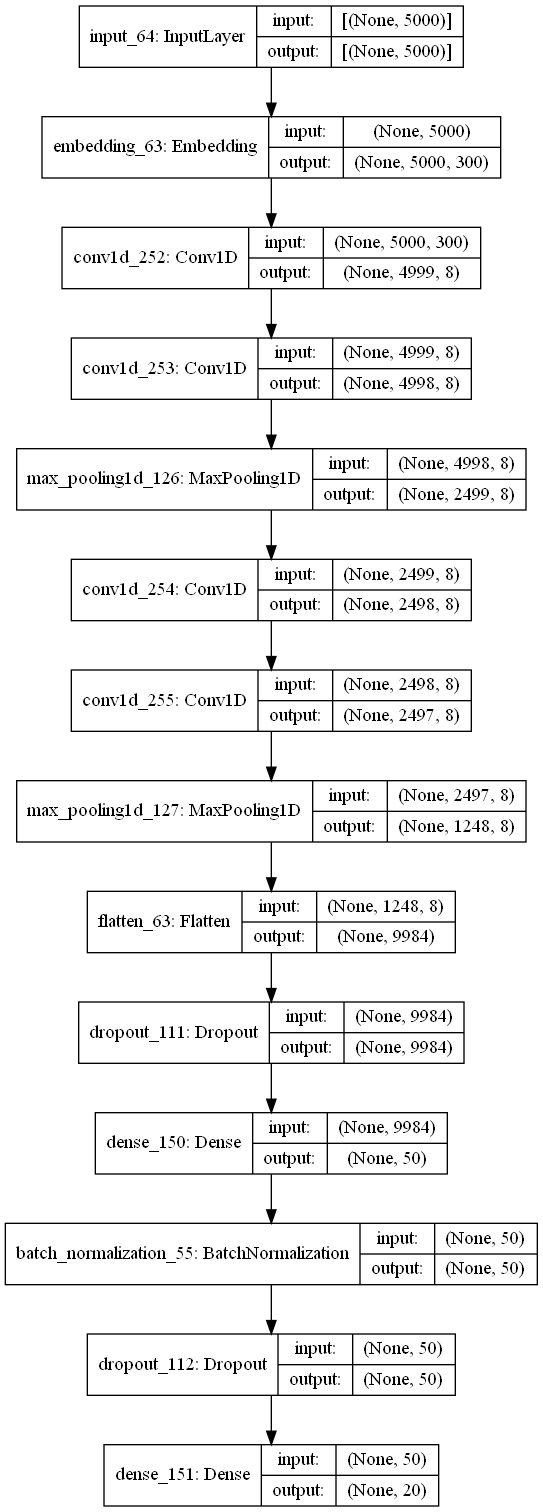